In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# 1. Read data

In [2]:
df = pd.read_csv('Financial news/all-data.csv', encoding='ISO-8859-1', header=None)
df

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [3]:
df.rename(columns={0: 'Label', 1: 'Sentence'}, inplace=True)

In [4]:
df

,Label,Sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


# 2. EDA

In [5]:
# Shape
df.shape

(4846, 2)

In [6]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Label     4846 non-null   object
 1   Sentence  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [7]:
# Check for NaN values
df.isna().sum()

Label       0
Sentence    0
dtype: int64

In [8]:
# Check for duplicates
df.duplicated().sum()

6

In [9]:
# Drop duplicates
df.drop_duplicates(inplace=True)

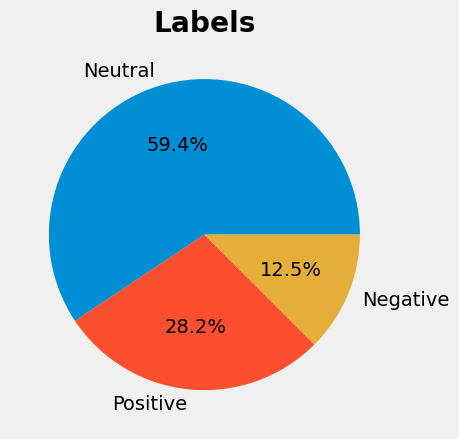

In [10]:
# Labels distribution
df['Label'].value_counts().plot(kind='pie', autopct="%1.1f%%", pctdistance=.6, labels=['Neutral', 'Positive', 'Negative'])
plt.title('Labels', fontweight='bold')
plt.ylabel('')
plt.show()

In [11]:
# Average length of all sentences
average_length = 0

for sentence in df['Sentence']:
    average_length+= len(sentence)


average_length /= len(df['Sentence'])
print(f"Average length of Sentences: {average_length:.2f}")

Average length of Sentences: 128.08


In [ ]:
def wordcount_gen(df, category):

    combined_texts = " ".join([text for text in df[df.Label == category]['Sentence']])
                          
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_texts))
    plt.title(f'{category} Sentiment Words\n', fontsize=20)
    plt.axis('off')
    plt.show()
    
wordcount_gen(df, 'positive')
     
wordcount_gen(df, 'negative')
     
wordcount_gen(df, 'neutral')

In [12]:
# Converting Target column into numerical 0, 1 and 2

encoder = LabelEncoder()
labels = ['negative', 'neutral', 'positive']

encoder.fit(labels)
df['Label'] = encoder.transform(df['Label'])

In [13]:
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype='<U8')

In [14]:
df

,Label,Sentence
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...
...,...,...
4841,0,LONDON MarketWatch -- Share prices ended lower...
4842,1,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,0,Operating profit fell to EUR 35.4 mn from EUR ...
4844,0,Net sales of the Paper segment decreased to EU...


# 3. Splitting

In [15]:
X_data = df.drop(columns=['Label'])
y_data = df['Label']

In [16]:
# Split all data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=26, test_size=0.2, stratify=y_data)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3872, 1), (968, 1), (3872,), (968,))

# 4. Data preprocessing

In [17]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ksush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ksush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
def preprocess_text(text):
    # Lower case
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    filtered_tokens = []
    # Remove stopwords and punctuation
    for token in tokens:
        if token not in string.punctuation and token not in stopwords.words('english'):
            filtered_tokens.append(token)

    tokens = filtered_tokens[:]
    # Clear list for further usage
    filtered_tokens.clear()

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    for token in tokens:
        filtered_tokens.append(lemmatizer.lemmatize(token))
    
    return " ".join(filtered_tokens)

In [19]:
X_train['Tokens'] = X_train['Sentence'].apply(preprocess_text)
X_test['Tokens'] = X_test['Sentence'].apply(preprocess_text)

# 5. Vectorization

* ### 5.1. Bag of Words

In [20]:
# BoW vectorization
bow = CountVectorizer(max_features=3000)

X_train_bow = bow.fit_transform(X_train['Tokens'])
X_test_bow = bow.transform(X_test['Tokens'])

print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}")


# To arrays
X_train_bow = X_train_bow.toarray()
X_test_bow = X_test_bow.toarray()

Shape of X_train_bow: (3872, 3000)
Shape of X_test_bow: (968, 3000)


* ### 5.2. TF-IDF

In [21]:
tfidf = TfidfVectorizer(max_features=3000)

X_train_tfidf = tfidf.fit_transform(X_train['Tokens'])
X_test_tfidf = tfidf.transform(X_test['Tokens'])

print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}")

# To arrays
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

Shape of X_train_tfidf: (3872, 3000)
Shape of X_test_tfidf: (968, 3000)


In [22]:
# The same for all vectorization methods
y_train = y_train.values
y_test = y_test.values